## Paper Reading-Fast RCNN



### Problems of R-CNN Model
1. Large number of candidate object locations must be processed.
2. Candidate provide rough localization that must be precised.

### Spatial Pyramid Pooling(SPPnet)
https://arxiv.org/pdf/1406.4729.pdf

### Model Architecture
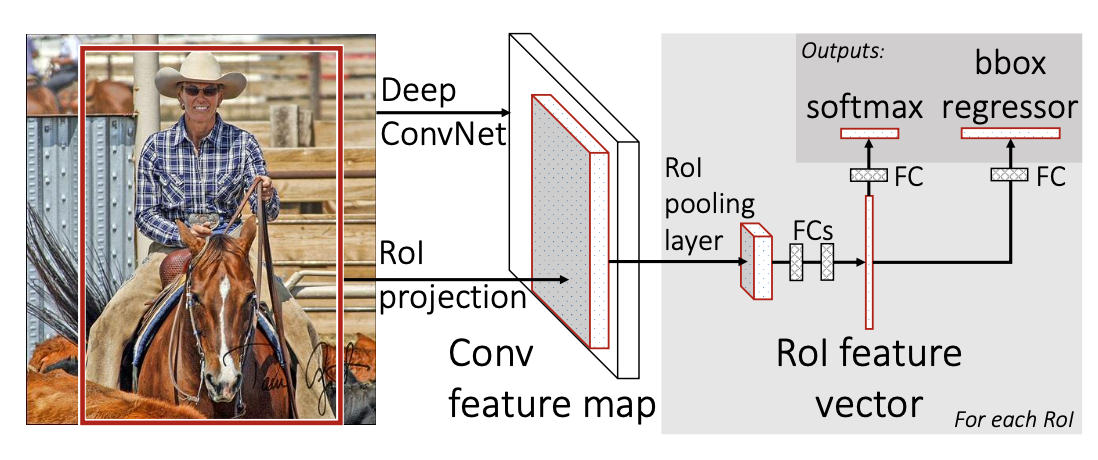

#### Process
1. Images input, use *selective search* to get region proposal(~2k).
2. Sent the original region proposals into <u>Conv and max pooling layers</u>, producing *conv feature map*.
3. Pooling layers of region of interest(ROI) extracts *feature vector* with a fixed length from feature map.
4. Feature vectors are sent into two FC layers
```
The two inputs in the model: a lists of images & RoIs of those images
```
5. Two Branches
   - FC layer→Softmax activation function→vector $(p_0,p_1,...,p_k)$ with length $K+1$ corresponding to each object + background class
   - FC layer→Bounding box regression for $K$ classes→4 real -valued numbers$t^k=(t_x^k,t_y^k,t_w^k,t_h^k)$, representing scale-invariant translation and log-space height/width shift based on object proposal.
6. Use NMS method to select few 



### ROI Pooling Layer
- ROI: rectangular window in a conv feature map.
  - Expression: $ROI:(x,y,w,h)$
    - $(x,y)$: top-left corner
    - $(w,h)$: width and height
- the pooling layer use max pooling to convert features of ROI into a small feature map with fixed spartial extent of $W*H$.(Sub-window size)
  - In the paper example, set $W=H=7$.
- size of output grid cell after maxpooling= $\frac{w}{W} * \frac{h}{H}$
- Back-propagation with RoI Pooling Layer
  - Compute the partial derivative of loss function with respect to each input $x_i$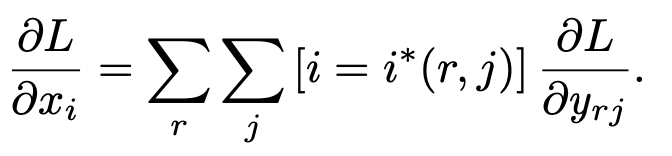
  - $y_{rj}$:pooling output unit, jth output from rth RoI
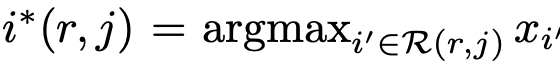 , where $R(x,y)$ index set of input in sub-window



### Fine-tuning
- Stochastic Gradient Descent(SGD) mini-batch are sampled hierarchically
  - Sampling $N$ images, set $N$=2
  - sampling $\frac{R}{N}$ RoIs from each image, set $R$=128
    - As results, we have totally 64 RoIs sampled from each image.
  - $IoU \space Threshold=0.5$
    - for [0.1,0.5): treated as background, $u=0$
    - for [0.5,1]: labeled as foreground object class, $u≥1$
  - SGD hyperparameter:
    - momentum=0.9
    - Initialization 
      - bias=0
      - FC layers for classification and BBox Regression~$Gaussian(𝛍=0,𝛅=0.01 or 0.001)$
    - learning rate=0.001 or 0.0001 or 0.0005
- Streamlined training process with one fine-tuning stage
- Which layers need fine-tuning?
  - training with RoI pooling layer is important for mAP performance
  - But not all layers need to be fine-tuned: >=Conv3_1 is enough.

#### Loss Function for Multi-tasks: Classification & Location Specify
- Notation:
  - $u$:ground-truth class
  - $v$: ground-truth bounding-box regression target
    - $v=(v_x,v_y,v_w,v_h)$
- Function: $L(p,u,t^u,v)=L_{cls}(p,u)+λ[u≥1]L_{loc}(t^u,v)$
   - $L_{cls}(p,u)=-logp_u$: log loss for true class u
   - $L_{loc}(t^u,v)=∑_{i∊{x,y,w,h}}smooth_L1(t_i^{u}-v_i)$
     - $t^u=(t_x^u,t_y^u,t_w^u,t_h^u)$: predicted tuple for class $u$.
     - Set $g=smooth_L1(t_i^{u}-v_i)$
     
     where g=
     \begin{cases}
     0.5x^2, if|x|<1 \\
     |x|-0.5, otherwise
     \end{cases}
- Train with $L1$ loss is less sensitive to outlier than $L2$ loss.
- Normalization: $v_i$~$distribution(μ=0,σ=1)$
- $\lambda=1$

### VGG16
- Model Architecture
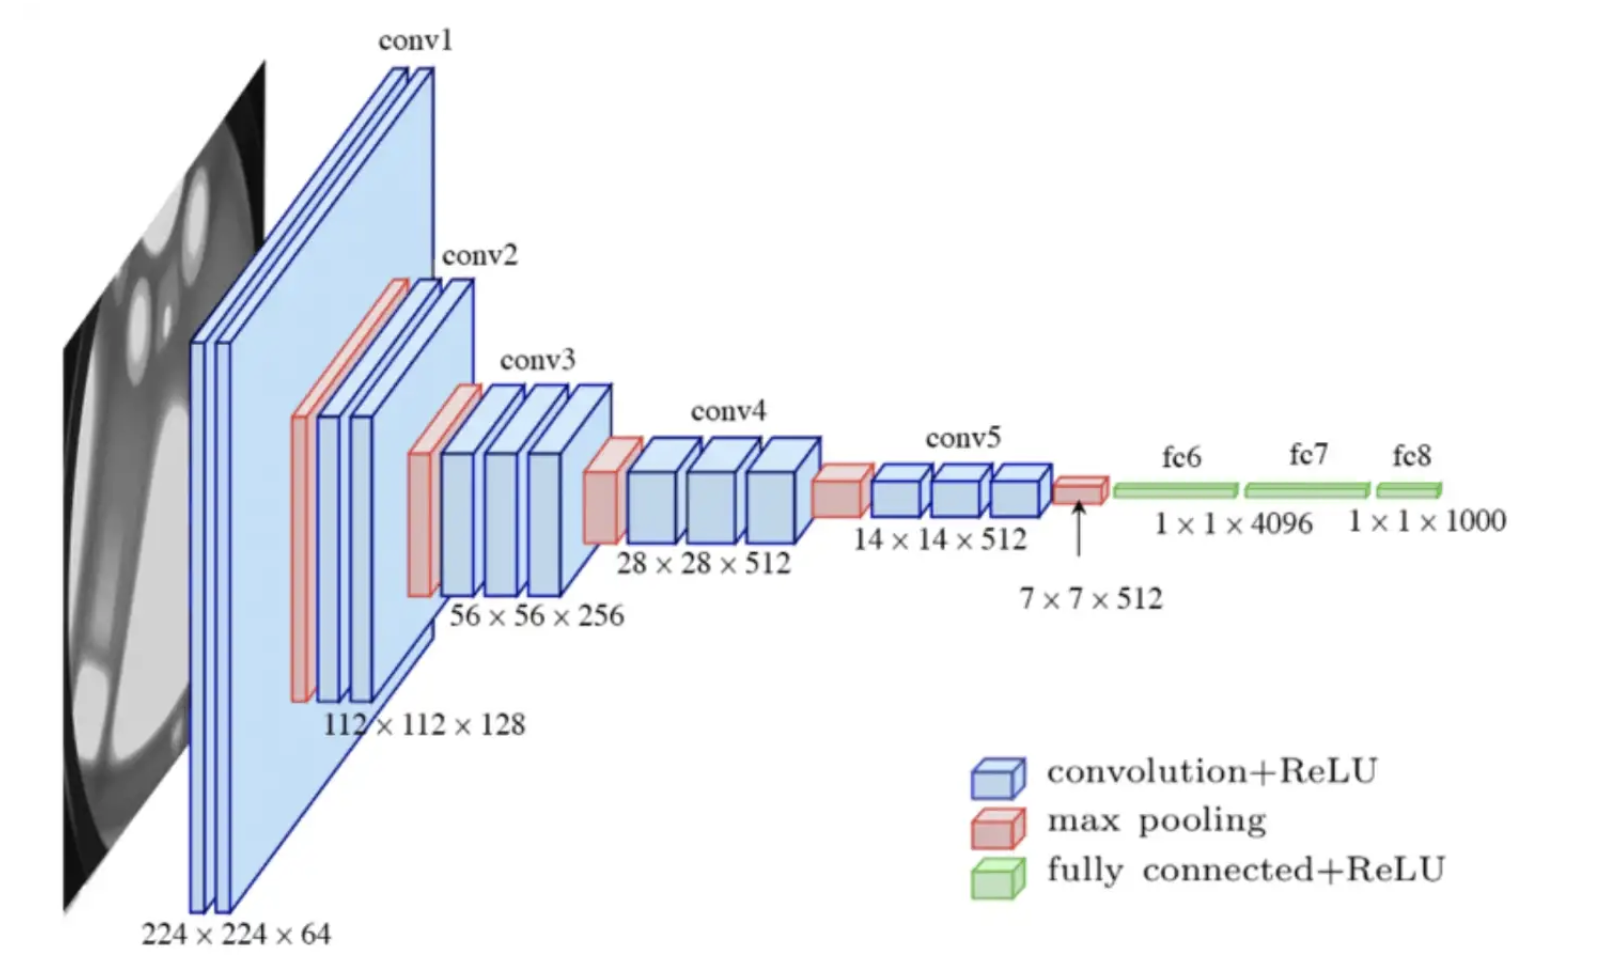

- Totally 13 Conventional layers + 3 Full Connected Layers(VGG16)
  - 13 Conv.Layer and 5 Max-pooling layers: feature extraction
  - 3 Full connected layers: classification task
- [VGG19: 16 conventional layers+3 Full connected layers]

- Width of Conv. layers: start from 64, then increased by factor of 2 after each max-pooling layers, reaching to 512 at final.
- None of them implement local response normalization(LRN) for reducing computation time and memory storage.
- Increasing the depth using small(3*3)filters
- use (3x3) kernel size and (2x2) maxpooling
- Input: 224*224 RGB,channel=3
- activation function:ReLU, except the last output layer is softmax
- Comparison between AlexNet: use several small-size kernels to replace a large-size kernel.
  - 2 (3x3) layers←5x5 layer
  - 3 (3x3) layers←7x7 layer

Hence, by this trick,the numbers of parameters are largely reduced.


In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.metrics import categorical_crossentropy
from keras.optimizers import SGD

In [8]:
def VGG16():
  model=Sequential() #initialization 

  model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',input_shape=(224,224,3)))
  model.add(Conv2D(filters=64,kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(units=1000, activation="softmax"))

  optimizer = SGD(lr = 0.01)
  model.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
  return model

In [9]:
VGG16_model=VGG16()
VGG16_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


#### Changes on VGG16 Architecture in Fast R-CNN Application
1. Replace the last max-pooling with ROI max-pooling layer.
2.  

### Truncated SVD
- for accelerating object detection with dimension reduction trick 
- number of Parameters: $uv$→$t(u+v)$
- Function: $W=U∑_tV^T$
  - $U$: a matrix with $u*t$
  - $W$: a matrix with $u*v$
  - $𝝨_t$: a t * t diagonal matrix containing top t singular values of $W$
- Coding
```
sklearn.decomposition.TruncatedSVD(n_components=2, *, algorithm='randomized', n_iter=5, n_oversamples=10, power_iteration_normalizer='auto', random_state=None, tol=0.0)
```
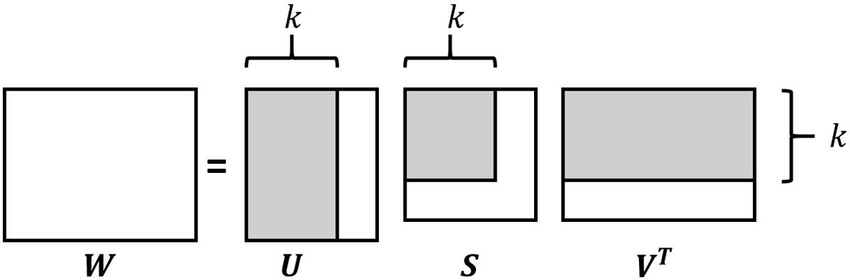

notes: we can change truncated level k in graph to t for case understanding in Fast R-CNN.

## References:
- 目标检测之Fast RCNN.https://zhuanlan.zhihu.com/p/43624561
- VGG16 paper: Very Deep Convolutional Networks for Large-scale Image Recognition.https://arxiv.org/pdf/1409.1556.pdf
